# CartPole Reinforcement Learning Project

This notebook demonstrates both **Q-Learning** and **Deep Q-Learning (DQN)** applied to the CartPole-v1 environment from OpenAI Gym. We will explore how an agent can learn to balance a pole using rewards through interaction.

## 1. Environment Setup
Install and import the required libraries.

In [20]:
!pip install gym numpy matplotlib torch --quiet

In [21]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque


## 2. Understand CartPole Dynamics
Let's initialize the environment and understand its observation and action space.

In [22]:
env = gym.make("CartPole-v1")
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


## 3. Q-Learning (Tabular Approach)
This method discretizes the state space and uses a table to store Q-values. This is limited but good for understanding the RL basics.

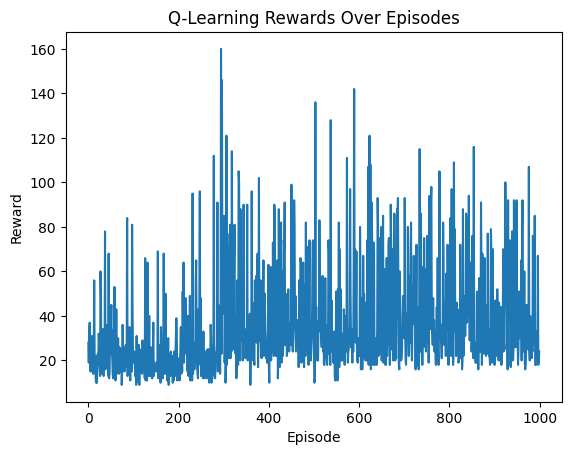

In [23]:
def create_bins(low, high, bins=10):
    return np.linspace(low, high, bins + 1)[1:-1]

def discretize(obs, bins):
    return tuple(np.digitize(x, b) for x, b in zip(obs, bins))

# Define bins for each dimension
bins = [create_bins(-4.8, 4.8), create_bins(-5, 5), create_bins(-0.418, 0.418), create_bins(-5, 5)]
q_table = np.zeros([10] * len(bins) + [env.action_space.n])

# Q-learning parameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
episodes = 1000
rewards = []

for ep in range(episodes):
    observation = env.reset()
    state = discretize(observation, bins)
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])
        obs, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        new_state = discretize(obs, bins)
        q_table[state][action] += alpha * (reward + gamma * np.max(q_table[new_state]) - q_table[state][action])
        state = new_state
        total_reward += reward
    epsilon *= 0.995
    rewards.append(total_reward)

plt.plot(rewards)
plt.title("Q-Learning Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## 4. Deep Q-Network (DQN)
We now use a neural network instead of a Q-table for continuous state spaces.

In [24]:
import numpy as np
np.bool8 = np.bool_  # 🔧 Patch for compatibility with older Gym versions

In [25]:
import numpy as np
np.bool8 = np.bool_  # 🔧 Patch for compatibility with older Gym versions

class DQN(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = DQN(obs_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

memory = deque(maxlen=2000)
gamma = 0.99
epsilon = 1.0
batch_size = 64
episodes = 300
reward_list = []

for ep in range(episodes):
    obs = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(model(torch.tensor(obs, dtype=torch.float32))).item()

        result = env.step(action)
        if len(result) == 5:
            next_obs, reward, terminated, truncated, _ = result
        else:
            next_obs, reward, done, _ = result
            terminated, truncated = done, False

        done = terminated or truncated

        memory.append((np.array(obs, dtype=np.float32), action, reward, np.array(next_obs, dtype=np.float32), done))
        obs = next_obs
        total_reward += reward

        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            obs_b, act_b, rew_b, next_b, done_b = zip(*batch)
            obs_b = torch.tensor(np.array(obs_b), dtype=torch.float32)
            act_b = torch.tensor(act_b, dtype=torch.int64)
            rew_b = torch.tensor(rew_b, dtype=torch.float32)
            next_b = torch.tensor(np.array(next_b), dtype=torch.float32)
            done_b = torch.tensor(done_b, dtype=torch.float32)

            q_vals = model(obs_b).gather(1, act_b.unsqueeze(1)).squeeze()
            next_q = model(next_b).max(1)[0]
            target = rew_b + gamma * next_q * (1 - done_b)

            loss = criterion(q_vals, target.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    epsilon *= 0.995
    reward_list.append(total_reward)

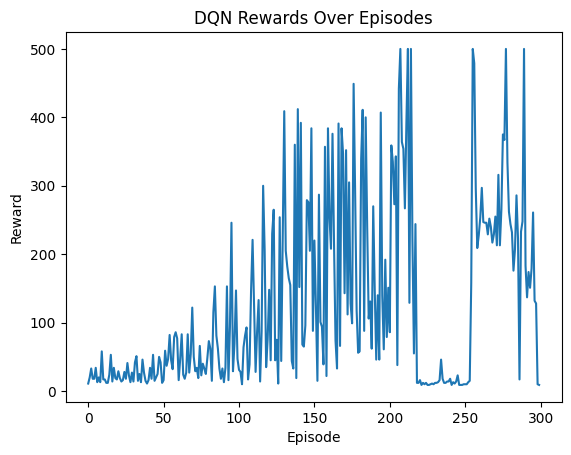

In [26]:
plt.plot(reward_list)
plt.title("DQN Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()